## Preparing Image Data for Processing with TensorFlow 2.x

![rose](https://images.unsplash.com/photo-1579053778004-3a4d3f0fae19?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=747&q=80)

In this tutorial, I am going to show to how to preparing image data using the flower dataset provided by TensorFlow. The flower dataset consists of five types of flowers and diverse image dimensions. 

First of all, let me import libraries.

In [1]:
#Importing libraries
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import PIL
import PIL.Image
import pathlib

## Loading Dataset

If you want you can directly load flower_photos dataset using get_file() method. This method downloads a file from a URL if it not already in the cache. You can find this method as follow:

In [2]:
# DATA_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
# data_dir = tf.keras.utils.get_file("flower_photos", DATA_URL, untar=True)

I am going to load dataset in kaggle input.

In [3]:
data_dir = "../input/flowers-recognition/flowers"

## Exploring the Dataset

Let me create a function to take a look pictures in dataset.

In [4]:
def display_image_in_actual_size(im_path):
    dpi = 100
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    # Hide spines, ticks, etc.
    ax.axis('off')
    # Display the image.
    ax.imshow(im_data, cmap='gray')
    plt.show()

Let me display a few picture of dataset.

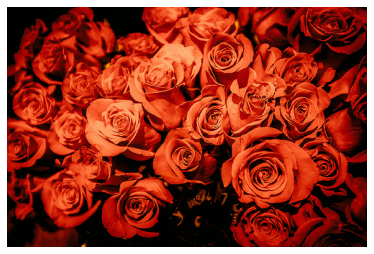

In [5]:
IMAGE_PATH = "../input/flowers-recognition/flowers/rose/10503217854_e66a804309.jpg"
display_image_in_actual_size(IMAGE_PATH)

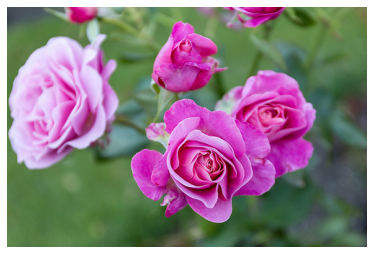

In [6]:
IMAGE_PATH = "../input/flowers-recognition/flowers/rose/11944957684_2cc806276e.jpg"
display_image_in_actual_size(IMAGE_PATH)

As you can see, the dimensions and aspect ratios of these images are different.

## Preprocessing the data

To use the ResNet model, I am going to convert image sizes into 224\*224 with three color channels (RGB). To do this, I am going to use ImageDataGenerator class and the flow_from_directory method.
 ImageDataGenerator creates a generator object, which generates streaming data from the directory as specified by flow_from_directory.

In [7]:
# Let's create keyword argument options.
pixels = 224
BATCH_SIZE = 32
IMAGE_SIZE = (pixels, pixels)
# And then I am going to pass them into their function calls:
datagen_kwargs = dict(rescale=1./255, 
                      validation_split = .20)
dataflow_kwargs = dict(target_size = IMAGE_SIZE, 
                       batch_size = BATCH_SIZE,
                      interpolation = "bilinear")
# Now that Create a generator object:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

Now you can determine the source directory. This generator will only stream 20% of the data, and this is designated as a validation dataset:

In [8]:
valid_generator = valid_datagen.flow_from_directory(data_dir, 
                                                    subset="validation", 
                                                    shuffle=False, 
                                                    **dataflow_kwargs)

Found 860 images belonging to 5 classes.


In [9]:
# Let's use same generator object for training data:
train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(data_dir, 
                                                    subset = "training",
                                                    shuffle = True, 
                                                    **dataflow_kwargs)

Found 3457 images belonging to 5 classes.


In [10]:
# Let's take a look shapes of batches image and label.
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 5)


Note that the output is NumPy arrays. For a batch of images, the sample size is 32, with 224 pixels in height and width and three channels representing RGB color space. For the label batch, there are likewise 32 samples. Each row is one-hot encoded to represent which of the five classes it belongs to.

## Training the Model

I have dataset consist of images arranged right format. It's ready the dataset to train model. I am going to use ResNet model in TensorFlow Hub, which is a library for loading trained models from TFHub in a single line of code. 

In [11]:
# First of all import tensorflow hub.
import tensorflow_hub as hub
# Built the model.
NUM_CLASSES = 5
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/4", trainable = False),
    tf.keras.layers.Dense(NUM_CLASSES, activation = "softmax")
])
model.build([None, 224, 224, 3])

In [12]:
# Let's take a look summary of the model. 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              42605504  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 42,615,749
Trainable params: 10,245
Non-trainable params: 42,605,504
_________________________________________________________________


## Compiling the model

In [13]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr = 0.005, momentum = 0.9),
             loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True,label_smoothing = 0.1),
             metrics = ["accuracy"])

## Training the model

In [14]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
model.fit(train_generator,
         epochs=5,
         steps_per_epoch = steps_per_epoch,
         validation_data = valid_generator,
         validation_steps = validation_steps)

Epoch 1/5
108/108 [==============================] - 558s 5s/step - loss: 1.5357 - accuracy: 0.6936 - val_loss: 0.9233 - val_accuracy: 0.8029
Epoch 2/5
108/108 [==============================] - 546s 5s/step - loss: 0.7134 - accuracy: 0.8852 - val_loss: 0.7897 - val_accuracy: 0.8293
Epoch 3/5
108/108 [==============================] - 555s 5s/step - loss: 0.6107 - accuracy: 0.9325 - val_loss: 0.7208 - val_accuracy: 0.8630
Epoch 4/5
108/108 [==============================] - 579s 5s/step - loss: 0.5626 - accuracy: 0.9537 - val_loss: 0.7455 - val_accuracy: 0.8546
Epoch 5/5
108/108 [==============================] - 576s 5s/step - loss: 0.6591 - accuracy: 0.9303 - val_loss: 0.7203 - val_accuracy: 0.8666


## Conclusion

That is all. In this tutorial, I showed how to prepar image data for preprocessing. I used flower photos dataset and ResNet, which is a prebuild model. This model usually is used for image dataset. 

## Resources

- [KC Tung, 2021, TensorFlow 2 Pocket Reference](https://www.amazon.com/TensorFlow-Pocket-Reference-Building-Deploying/dp/1492089184)
- [TensorFlow Tutorial](https://www.tensorflow.org/tutorials)

Don't forget to follow on Tirendaz Academy [YouTube-Tr](https://youtube.com/c/tirendazakademi), [YouTube-Eng](https://www.youtube.com/channel/UCFU9Go20p01kC64w-tmFORw), [Twitter](https://twitter.com/TirendazAcademy), [Medium](https://tirendazacademy.medium.com), [GitHub](https://github.com/TirendazAcademy) and [LinkedIn](https://www.linkedin.com/in/tirendaz-academy)